## Multivariate Single step forecast, Recursively applied to output to generate continuing forecast horizon

In [9]:
import pandas as pd
import numpy as np
from numpy import array
from numpy import mean
from numpy import std
from keras.models import Sequential
from tensorflow.keras.layers import LSTM
from keras.layers import Dense
import matplotlib.pyplot as plt
from keras.layers import TimeDistributed
from sklearn.preprocessing import MinMaxScaler

In [10]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out, step_interval):
    X, y = list(), list()
    example_count = int((len(sequence)/step_interval))
    for i in range(example_count):
        # find the end of this pattern
        end_ix = (i*step_interval) + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[(i*step_interval):end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [16]:
resample_rate = '5T'
start_date='2021-11-26 00:00:00'
end_date='2022-01-26 23:55:00' 
inputs = ['min_gas_price']
#No of timesteps behind to forecast on, no of timesteps to forecast ahead
n_steps_in = 2016
n_steps_out = 1
#How many timesteps between start of training examples
step_interval = 1

Load data, datetime to index, downsample with left edge label, convert wei to gwei

In [239]:
#Load data as float, datetime to index
data = pd.read_csv (r'C:\Users\conal\Desktop\MCM\Practicum\data\min,max,average gas 11-26 to 01-26 QUERY 2.csv', header=0)
data['block_timestamp'] = pd.to_datetime(data['block_timestamp'], format = '%Y-%m-%d %H:%M:%S UTC')
data = data.set_index('block_timestamp')
data = data.squeeze()
data = data.astype('float')

#Resample with left edge label i.e min 1-5 mean labelled as min1
data = data.resample(resample_rate).mean()
data
#Convert to gwei
data = data.apply(lambda x: x/1000000000)
data =data[inputs]

#Filter inputs
data =data[inputs]
scaler = MinMaxScaler()
data[inputs] = scaler.fit_transform(data[inputs])
    

#Creat input:output examples
data = data[start_date:end_date].to_numpy()
X, y = split_sequence(data, n_steps_in, n_steps_out, step_interval)
y = y[:, :, :1]
X_train, X_val = np.split(X, [int(0.7 * len(X))])
#we are only lookign to forecast the min gas price
y_train, y_val = np.split(y, [int(0.7 * len(X))])



In [240]:
#Reshape to 3D for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], len(inputs)))
y_train =y_train.reshape((y_train.shape[0], y_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], len(inputs)))
y_val = y_val.reshape((y_val.shape[0], y_val.shape[1], 1))

In [130]:
# define model
model = Sequential()
model.add(LSTM(512, activation='tanh', input_shape=(n_steps_in, len(inputs))))
model.add(Dense(n_steps_out))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

In [243]:
model.fit(X_train, y_train, epochs=10, verbose=1)

Epoch 1/10
347/347 [==============================] - 55s 153ms/step - loss: 4.5311e-04
Epoch 2/10
347/347 [==============================] - 53s 153ms/step - loss: 3.4511e-04
Epoch 3/10
347/347 [==============================] - 57s 163ms/step - loss: 3.5285e-04
Epoch 4/10
347/347 [==============================] - 60s 174ms/step - loss: 3.4973e-04
Epoch 5/10
347/347 [==============================] - 57s 165ms/step - loss: 3.5325e-04
Epoch 6/10
347/347 [==============================] - 56s 162ms/step - loss: 3.5058e-04
Epoch 7/10
347/347 [==============================] - 56s 161ms/step - loss: 3.4491e-04
Epoch 8/10
347/347 [==============================] - 54s 157ms/step - loss: 3.5018e-04
Epoch 9/10
347/347 [==============================] - 58s 167ms/step - loss: 3.4203e-04
Epoch 10/10
347/347 [==============================] - 54s 156ms/step - loss: 3.4454e-04


In [244]:
from sklearn.preprocessing import MinMaxScaler

In [245]:
from sklearn.metrics import r2_score

In [246]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
yhat = model.predict(X_val, verbose=1)




149/149 [==============================] - 10s 64ms/step


RMSE 40.022605061614826
MAE 18.123736620438283
MAPE 0.10676280083988128
R^2 0.647832183088656


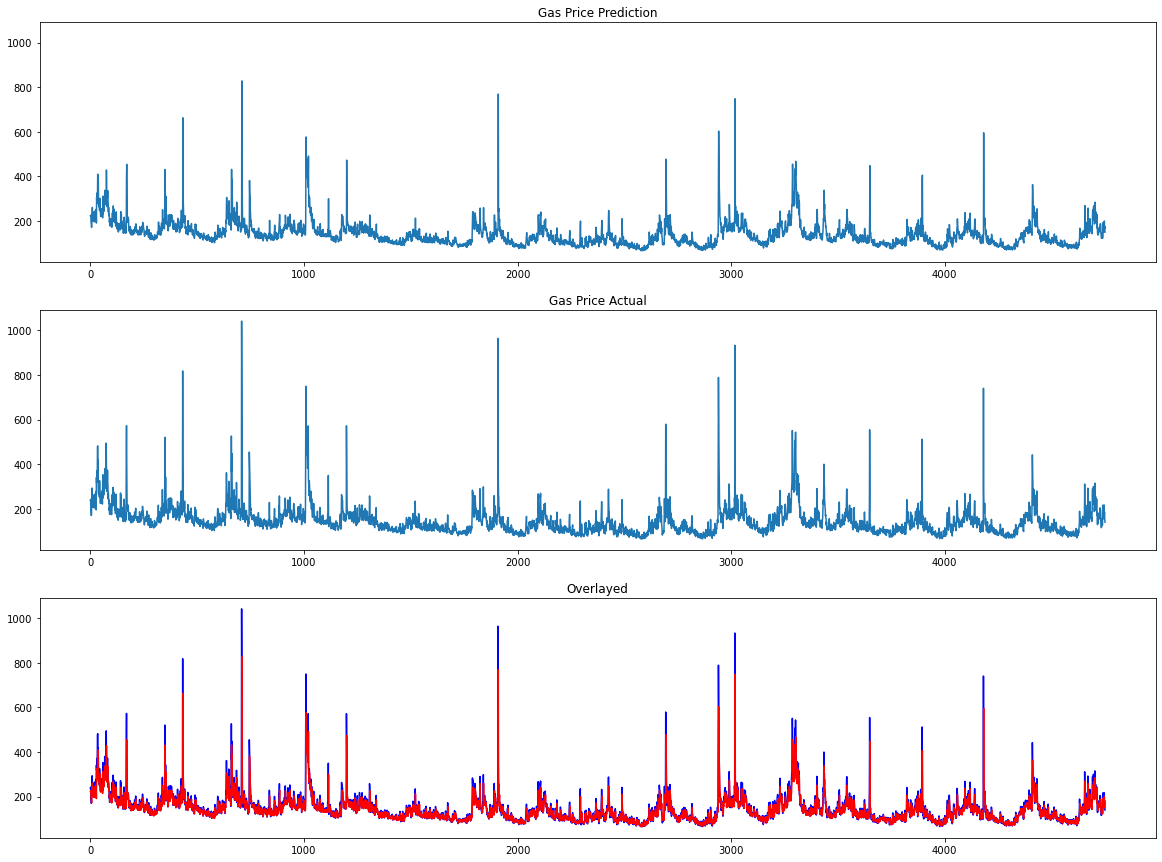

In [247]:
#Minmax scaler has been fit with 2d data, add a dummy column to results array
pred_descaled= (scaler.inverse_transform(array([yhat,]*2).transpose()[0]))[:, :1]
groud_truth_descaled= (scaler.inverse_transform(array([y_val,]*2).transpose()[0][0]))[ :, :1]


f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True)
f.set_figwidth(20)
f.set_figheight(15)
ax1.plot(pred_descaled)
ax1.title.set_text('Gas Price Prediction')
ax2.plot(groud_truth_descaled)
ax2.title.set_text('Gas Price Actual')


ax3.title.set_text('Overlayed')
ax3.plot(groud_truth_descaled, color='blue',label='Predicted '+' Gas Price')
ax3.plot(pred_descaled, color='red',label='real '+' Gas Price')



print('RMSE ' + str(mean_squared_error(groud_truth_descaled, pred_descaled, squared=False)))
print('MAE ' + str(mean_absolute_error(groud_truth_descaled, pred_descaled)))
print('MAPE ' + str(mean_absolute_percentage_error(groud_truth_descaled, pred_descaled)))
print('R^2 ' + str(r2_score(groud_truth_descaled, pred_descaled)))

## Lets add a recursive prediction based on the one step ahead forecast


In [248]:
# Define max lookahead
lookahead = 288
forecasts = []
X_val_recursive = X_val
for i in range (0, lookahead):
    #Forecast one step ahead
    yhat_Step = model.predict(array([X_val_recursive[-1]]), verbose=0)
    #Record each forecast
    forecasts.append(yhat_Step)
    #Add most recent forecast to end of inputs, remove first timestep in pinputs to keep constant length
    X_val_recursive = array([np.append(X_val_recursive[-1][1:], (yhat_Step), axis=0)])
    

In [251]:
X_val_recursive = X_val
yhat_Step = model.predict(array([X_val_recursive[-1]]), verbose=0)
yhat_Step

array([[0.08716392]], dtype=float32)

In [249]:
forecasts_flat = []
for i in forecasts:
    forecasts_flat.append(i.tolist())

## Looks like the model continues a downward trend after one low prediction, any noise or random fluctuations in the preceeding predictions appears like it adversely affect succeeding predictions

RMSE 146.94629706275293
MAE 130.62480624446619
MAPE 0.5976293015175437
R^2 -3.0571602053588727


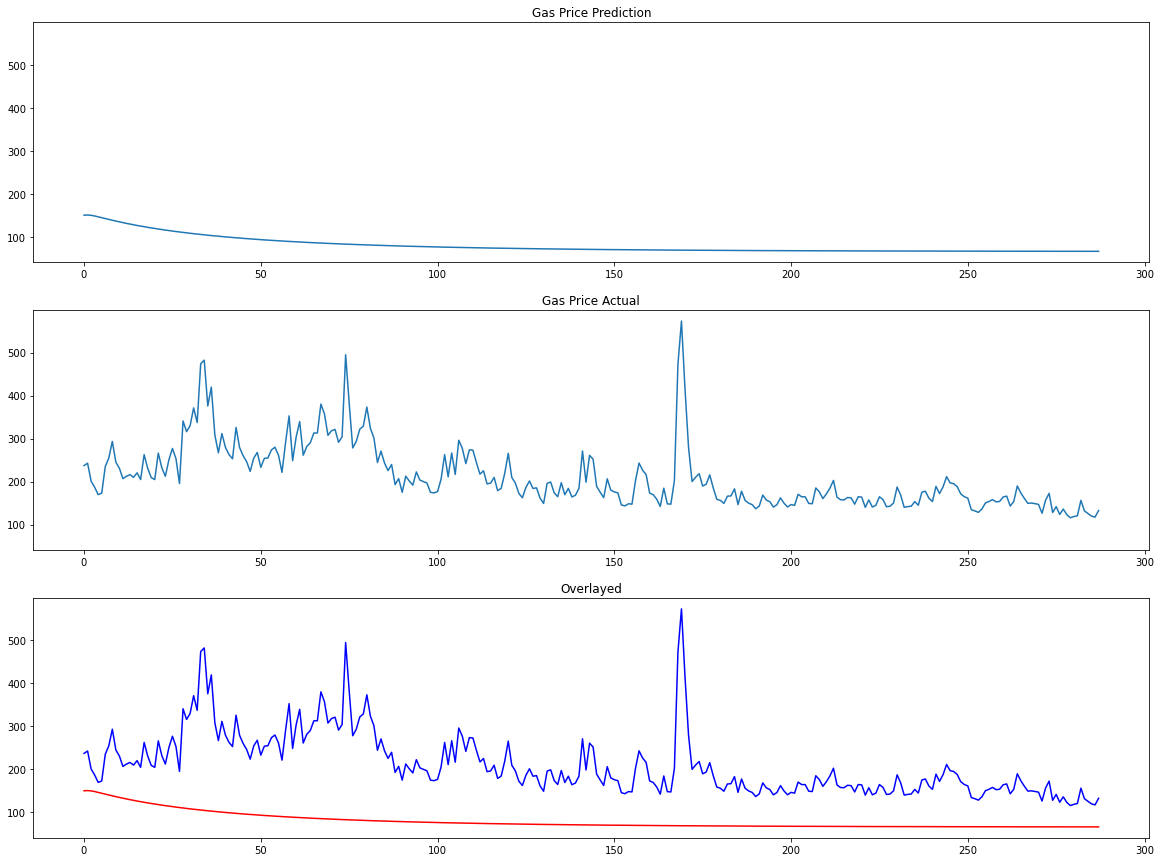

In [250]:
#Minmax scaler has been fit with 2d data, 
pred_descaled= (scaler.inverse_transform(array(forecasts_flat*len(inputs)).transpose()[0]))[0]
groud_truth_descaled= (scaler.inverse_transform(array([y_val[:288],]*len(inputs)).transpose()[0][0]))[ :, :1]


f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True)
f.set_figwidth(20)
f.set_figheight(15)
ax1.plot(pred_descaled)
ax1.title.set_text('Gas Price Prediction')
ax2.plot(groud_truth_descaled)
ax2.title.set_text('Gas Price Actual')


ax3.title.set_text('Overlayed')
ax3.plot(groud_truth_descaled, color='blue',label='Predicted '+' Gas Price')
ax3.plot(pred_descaled, color='red',label='real '+' Gas Price')



print('RMSE ' + str(mean_squared_error(groud_truth_descaled, pred_descaled, squared=False)))
print('MAE ' + str(mean_absolute_error(groud_truth_descaled, pred_descaled)))
print('MAPE ' + str(mean_absolute_percentage_error(groud_truth_descaled, pred_descaled)))
print('R^2 ' + str(r2_score(groud_truth_descaled, pred_descaled)))

In [199]:
pred_descaled= (scaler.inverse_transform(array([yhat,]*len(inputs)).transpose()[0]))